In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!unzip -qq /content/drive/MyDrive/dataset.zip

In [3]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import tqdm

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Data preporation

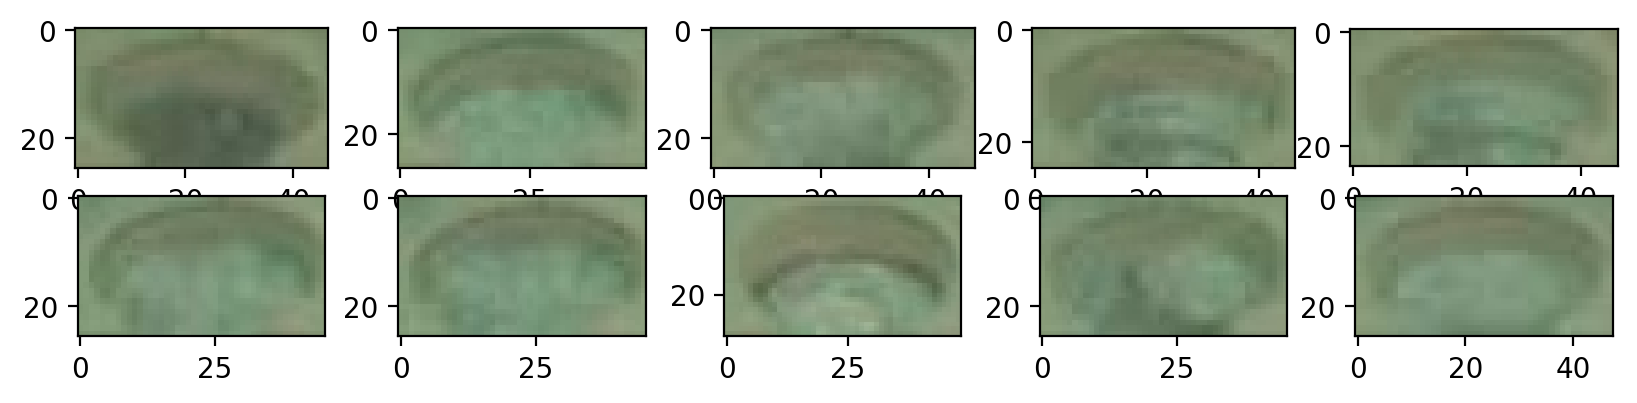

In [5]:
import os
import cv2

imgs = [cv2.imread(f'./dataset/train/{fn}') for fn in os.listdir('./dataset/train/')]

fig, axis = plt.subplots(ncols=5, nrows=2, figsize=(10, 2))
for i, img in enumerate(imgs[:10]):
  axis[i // 5, i % 5].imshow(img)
plt.show()

In [6]:
input_shape = (np.median([e.shape[0] for e in imgs]).astype(int),
               np.median([e.shape[1]for e in imgs]).astype(int))

In [7]:
def preprocess_images(imgs, input_shape):
  imgs = [cv2.cvtColor(e, cv2.COLOR_RGB2GRAY) for e in imgs]
  imgs = [cv2.resize(e, input_shape, interpolation=cv2.INTER_CUBIC) for e in imgs]
  imgs = np.array(imgs) / 255
  return torch.Tensor(imgs).to(device)

In [8]:
imgs = preprocess_images(imgs, input_shape)
data = torch.utils.data.DataLoader(imgs, batch_size=128, shuffle=True)

# Model init

In [22]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(1296, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [23]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 1296)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 48, 27))

In [24]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# Model train

In [40]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        losses = 0
        for x in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            losses += loss
            loss.backward()
            opt.step()
        if epoch % 10 == 9:
          print(epoch, float(losses / len(data)))
    return autoencoder

In [41]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU

In [42]:
autoencoder = train(autoencoder, data, epochs=100)

9 33242.6640625
19 33226.23046875
29 33155.60546875
39 33104.03125
49 33079.98046875
59 33065.51171875
69 33057.51171875
79 33057.24609375
89 33058.86328125
99 33037.93359375
